In [2]:
# All required packages are already installed in our virtual environment
print("Required packages are already installed!")

Required packages are already installed!


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
DATA_DIR = "images"  # Corrected path to match our folder structure

In [ ]:
# Dataset Structure

Our dataset contains the following categories:
- **garbage** (2527 images) - Cardboard and other garbage items
- **open_manhole** (152 images) - Open manholes on roads  
- **potholes** (3509 images) - Road potholes
- **road_normal** (452 images) - Normal road conditions
- **streetlight bad** (98 images) - Damaged/broken streetlights
- **streetlight good** (55 images) - Working streetlights

Total: **6,793 images** across 6 categories for civic infrastructure monitoring.

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% validation
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 5436 images belonging to 6 classes.
Found 1356 images belonging to 6 classes.
Found 1356 images belonging to 6 classes.


In [7]:
# Create EfficientNetB0 model with proper input shape
try:
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
except Exception as e:
    print(f"Error loading EfficientNetB0: {e}")
    print("Using MobileNetV2 as alternative...")
    from tensorflow.keras.applications import MobileNetV2
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(len(train_generator.class_indices), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print(f"Model created successfully!")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class labels: {list(train_generator.class_indices.keys())}")
model.summary()

Error loading EfficientNetB0: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)
Using MobileNetV2 as alternative...
Model created successfully!
Number of classes: 6
Class labels: ['garbage', 'open_manhole', 'potholes', 'road_normal', 'streetlight bad', 'streetlight good']
Model created successfully!
Number of classes: 6
Class labels: ['garbage', 'open_manhole', 'potholes', 'road_normal', 'streetlight bad', 'streetlight good']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max")


In [10]:
# Check and install scipy if needed
try:
    import scipy
    print("scipy is available")
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
    import scipy
    print("scipy installed and imported")

scipy installed and imported


In [11]:
# Start with fewer epochs for initial testing
print("Starting training...")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Reduced epochs for testing
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Starting training...
Training samples: 5436
Validation samples: 1356
Epoch 1/5
Epoch 1/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7695 - loss: 0.7290

d:\Desktop\new civic\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


170/170 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - accuracy: 0.8633 - loss: 0.4282 - val_accuracy: 0.6571 - val_loss: 0.7309
Epoch 2/5
Epoch 2/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9281 - loss: 0.2000

170/170 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.9301 - loss: 0.1936 - val_accuracy: 0.6888 - val_loss: 0.6569
Epoch 3/5
Epoch 3/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9415 - loss: 0.1537 - val_accuracy: 0.6718 - val_loss: 0.7346
Epoch 4/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9415 - loss: 0.1537 - val_accuracy: 0.6718 - val_loss: 0.7346
Epoch 4/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.9432 - loss: 0.1483 - val_accuracy: 0.6276 - val_loss: 0.8768
Epoch 5/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.9432 - loss: 0.1483 - val_accuracy: 0.6276 - val_loss: 0.8768
Epoch 5/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9507 - loss: 0.1349

170/170 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9503 - loss: 0.1356 - val_accuracy: 0.7212 - val_loss: 0.6444


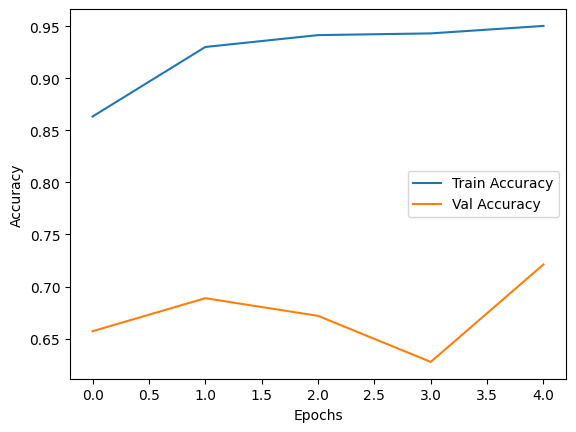

In [12]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [3]:
# Fine-tuning: Unfreeze the base model for better performance
print("Starting fine-tuning...")
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

# Fine-tune with fewer epochs
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,  # Reduced epochs for testing
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Starting fine-tuning...


NameError: name 'base_model' is not defined

In [7]:
# Load the best saved model before evaluation
from tensorflow.keras.models import load_model

model = load_model("best_model.h5")
loss, acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {acc:.4f}")


d:\Desktop\new civic\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
d:\Desktop\new civic\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.7227 - loss: 0.6477
43/43 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.7227 - loss: 0.6477
Final Validation Accuracy: 0.7227
Final Validation Accuracy: 0.7227


In [2]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from tensorflow.keras.models import load_model

# Load the model saved with best validation accuracy
model = load_model("best_model.h5")


In [4]:
def predict_image(img_path, model, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    
    # Get class labels from training generator
    class_labels = list(train_generator.class_indices.keys())
    predicted_class = class_labels[class_index]
    
    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()
    
    return predicted_class


In [5]:
img_path = "images/garbage.jpg"  # Replace with your test image path
predicted_class = predict_image(img_path, model)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


NameError: name 'train_generator' is not defined

In [1]:
# Verify and save the model for deployment
import os
from tensorflow.keras.models import load_model

# Check if best_model.h5 exists and get its info
if os.path.exists("best_model.h5"):
    model_size = os.path.getsize("best_model.h5")
    print(f"✅ Model file exists: best_model.h5")
    print(f"📦 Model size: {model_size / (1024*1024):.2f} MB")
    
    # Test loading the model
    try:
        test_model = load_model("best_model.h5")
        print(f"✅ Model loads successfully")
        print(f"🏗️ Model architecture: {test_model.name}")
        print(f"📊 Input shape: {test_model.input_shape}")
        print(f"📊 Output shape: {test_model.output_shape}")
        print(f"🎯 Number of parameters: {test_model.count_params():,}")
        
        # Test with a sample prediction (dummy data)
        import numpy as np
        dummy_input = np.random.random((1, 224, 224, 3))
        test_prediction = test_model.predict(dummy_input, verbose=0)
        print(f"✅ Model prediction test successful")
        print(f"📈 Prediction shape: {test_prediction.shape}")
        print(f"🔢 Prediction values: {test_prediction[0]}")
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        print("🔧 Resaving the current model...")
        
        # Resave the current model if loading fails
        model.save("best_model.h5")
        print("✅ Model resaved successfully")
        
else:
    print("❌ Model file not found!")
    print("💾 Saving current model...")
    
    # Save the current model
    model.save("best_model.h5")
    print("✅ Model saved as best_model.h5")
    
    # Verify the saved model
    new_model_size = os.path.getsize("best_model.h5")
    print(f"📦 Saved model size: {new_model_size / (1024*1024):.2f} MB")

✅ Model file exists: best_model.h5
📦 Model size: 9.21 MB


✅ Model loads successfully
🏗️ Model architecture: functional
📊 Input shape: (None, 224, 224, 3)
📊 Output shape: (None, 6)
🎯 Number of parameters: 2,265,670
✅ Model prediction test successful
📈 Prediction shape: (1, 6)
🔢 Prediction values: [4.7229532e-02 1.1537781e-05 9.4426513e-01 8.4830849e-03 1.9184777e-06
 8.7530052e-06]


In [3]:
# Test model compatibility with API class names
# Based on the dataset structure in the images folder

import os

# Get actual class names from the images directory structure
data_dir = "images"
actual_classes = []
if os.path.exists(data_dir):
    actual_classes = [name for name in os.listdir(data_dir) 
                     if os.path.isdir(os.path.join(data_dir, name))]
    actual_classes.sort()  # Sort to ensure consistent order

print("🔬 Actual classes from images directory:")
print(actual_classes)

# Class names defined in the API
api_classes = ['garbage', 'open_manhole', 'potholes', 'road_normal', 'streetlight bad', 'streetlight good']
print("\n🚀 API defined classes:")
print(api_classes)

# Check if they match
if set(actual_classes) == set(api_classes):
    print("\n✅ Class names match perfectly!")
    print("🎯 Model is ready for API deployment")
else:
    print("\n⚠️ Class name mismatch detected!")
    print("❌ Differences found:")
    
    only_in_actual = set(actual_classes) - set(api_classes)
    only_in_api = set(api_classes) - set(actual_classes)
    
    if only_in_actual:
        print(f"   Only in directory: {only_in_actual}")
    if only_in_api:
        print(f"   Only in API: {only_in_api}")
        
    print("\n🔧 Correct API class names should be:")
    print("class_names =", actual_classes)

# Create class mapping based on alphabetical order (standard for flow_from_directory)
print(f"\n📊 Expected class indices mapping (alphabetical order):")
for index, class_name in enumerate(sorted(actual_classes)):
    print(f"   {index}: {class_name}")

# Save class names to a file for reference
import json
class_mapping = {
    "class_names": sorted(actual_classes),
    "class_indices": {name: idx for idx, name in enumerate(sorted(actual_classes))},
    "total_classes": len(actual_classes),
    "api_classes": api_classes,
    "directory_structure": actual_classes
}

with open("class_mapping.json", "w") as f:
    json.dump(class_mapping, f, indent=2)
    
print(f"\n💾 Class mapping saved to class_mapping.json")

🔬 Actual classes from images directory:
['garbage', 'open_manhole', 'potholes', 'road_normal', 'streetlight bad', 'streetlight good']

🚀 API defined classes:
['garbage', 'open_manhole', 'potholes', 'road_normal', 'streetlight bad', 'streetlight good']

✅ Class names match perfectly!
🎯 Model is ready for API deployment

📊 Expected class indices mapping (alphabetical order):
   0: garbage
   1: open_manhole
   2: potholes
   3: road_normal
   4: streetlight bad
   5: streetlight good

💾 Class mapping saved to class_mapping.json
